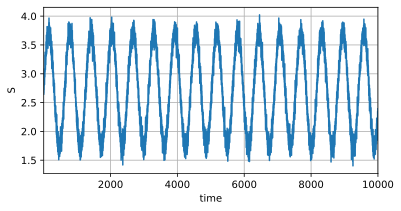

In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import time
T = 10000  # 总共产生1000个点
total_time = torch.arange(1, T + 1, dtype=torch.float32)
beta=torch.tensor(1.0)
gamma=torch.exp(torch.tensor(1))
I=torch.sin(0.01*total_time)
S = gamma+beta*I+torch.normal(0, 0.1, (T,))
d2l.plot(total_time, [S], 'time', 'S', xlim=[1, 10000], figsize=(6, 3))
tau = 4
device=d2l.try_gpu()

In [2]:
print(S)

tensor([2.7088, 2.7347, 2.6437,  ..., 2.2749, 2.2953, 2.3928])


In [3]:
def get_data(data,tau,T):
    features = torch.zeros((T - tau, tau))
    for i in range(tau):
        features[:, i] = data[i: T - tau + i]
    labels = S[tau:].reshape((-1, 1))
    batch_size, n_train = 10, 8000
    train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size, is_train=True)
    return train_iter,features,labels

In [4]:
S_train,S_features,S_labels=get_data(S,tau,T)
I_train,I_features,I_labels=get_data(I,tau,T)

In [5]:
class parameter_layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(parameter_layer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_normal_(param)
            elif 'bias' in name:
                torch.nn.init.constant_(param, 0.0)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        # 转换维度
        x = x.view(x.size(0), 1, x.size(1))
        # 前向
        out, _ = self.lstm(x, (h0, c0))
        # 解码
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class MyLinear(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLinear,self).__init__()
        self.beta = parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.gamma=parameter_layer(input_size, hidden_size, num_layers, output_size)
        self.I=nn.Sequential(
            nn.Linear(input_size,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
        # self.w = nn.Parameter(torch.randn(1),requires_grad=True)
        # self.S=nn.Sequential(
        #     nn.Linear(in_units,1)
        # )
    def forward(self, x):
        linear =self.beta(x)*self.I(x) +self.gamma(x)       # print(linear)
        return linear

In [7]:
# device='cpu'

In [8]:
net=MyLinear(tau,128,1,1)
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)
net.apply(init_weights)
net.to(device)
loss_S = nn.MSELoss()
loss_I=nn.MSELoss()
trainer_S = torch.optim.SGD(net.beta.parameters(), lr=0.01)
trainer_I = torch.optim.SGD(net.I.parameters(), lr=0.01)
# scheduler_S=torch.optim.lr_scheduler.StepLR(trainer_S,1,gamma=0.95)
# scheduler_I=torch.optim.lr_scheduler.StepLR(trainer_I,1,gamma=0.95)

In [9]:
num_epochs = 15
S_features=S_features.to(device)
S_labels=S_labels.to(device)
I_features=I_features.to(device)
I_labels=I_labels.to(device)
start=time.time()
for epoch in range(num_epochs):
    for (X_S, y_S),(X_I,y_I) in zip(S_train,I_train):
        X_S=X_S.to(device)
        y_S=y_S.to(device)
        X_I=X_I.to(device)
        y_I=y_I.to(device)

        l_S = loss_S(net(X_S) ,y_S)
        trainer_S.zero_grad()

        l_I=loss_I(net.I(X_I),y_I)
        trainer_I.zero_grad()

        l_total=l_S+l_I
        l_total.backward()
        trainer_S.step()
        trainer_I.step()

    l = loss_S(net(S_features), S_labels)+loss_I(net.I(I_features),I_labels)
    print(f'epoch {epoch + 1}, loss {l:f}')
    # scheduler_S.step()
    # scheduler_I.step()
print(time.time()-start)

torch.Size([10, 4])


NameError: name 'ss' is not defined

In [19]:
net.to(device)

MyLinear(
  (beta): parameter_layer(
    (lstm): LSTM(4, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=1, bias=True)
  )
  (gamma): parameter_layer(
    (lstm): LSTM(4, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=1, bias=True)
  )
  (I): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [33]:
net.beta(S_features).mean()

tensor(0.4574, device='cuda:0', grad_fn=<MeanBackward0>)

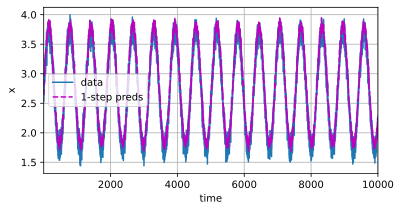

In [34]:
net.to('cpu')
onestep_preds = net(S_features.cpu())
d2l.plot([total_time, total_time[tau:]],
         [S.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 10000],
         figsize=(6, 3))

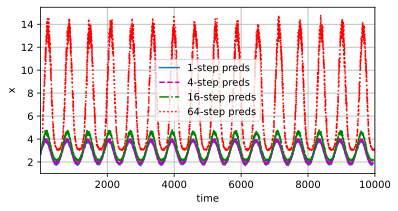

In [35]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = S[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([total_time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 10000],
         figsize=(6, 3))